In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import keras
import cv2

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = dataset
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print (x)
    return (max(train_length_values))

In [2]:
from distutils.version import LooseVersion
from collections import OrderedDict
import cv2
import fnmatch
from PIL import Image
from copy import deepcopy
from scipy.misc import imresize
import re
from scipy import stats


class DataLoader():
    def __init__(self, seq_length = None,shuffle=True, augment=None, start=0, step = 1, frag_len = 50):
        self.seq_length = seq_length
        self.step = 1
        #self.Xs = []
        #self.ys = []
        self.augment = augment
        self.frames = []
        self.labels = []
        self.start = start
        self.step = step
        self.frag_len = frag_len
        
        #print("Number of elements: \n")
        #print(self.nb_elements)
    
    def _add_frame(self, i, frame):
        """
        frame : image frame to append to image sequence
        """ 
        frame = self._resizer(frame,(256,400))
        self.frames.append(frame)
            
    def _add_labels(self, i, label_img):
        """
        label_img : segmentation frame to append to segmentation sequence
        """ 
        _cls = imresize(label_img,(400,256))
        self.labels.append(_cls)

    def _resizer(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        return data
    
    def _sequence_segmenter(self,sequence, frag_len, step):
        """
        sequence[list of lists]: the image sequence
        frag_len[int]: how long each fragment length will be or number of repeated LSTM units. divisible by sequnce length
        step[int]: steps taken between frames
        """
        samples = [sequence[i:i + frag_len] for i in range(0, len(sequence), frag_len)]
        return samples


    def load_data(self,file_name):
         # Store sample
        input_dir, input_n = os.path.split(file_name)
        input_name, ext = os.path.splitext(input_n)
        if ext not in ('.avi', '.mp4', '.tif'):
            raise IOError('Format %s not supported' % (ext))
        
        # Find matching label file
        label_file = None
        for f in os.listdir(input_dir):
            if fnmatch.fnmatch(f, input_name  + '.label.tif'):
                label_file = f
                break

        # Read multi-page label tif using PIL
        if label_file is None:
            print(input_name + '' + '.label.tif' + ' Not found')
            raise IOError('Label file not found')    
        
    
        # Read video in frame by frame as list of lists
        if ext in ('.avi', '.mp4'):
            print("Processing an avi file...")
            video = cv2.VideoCapture(file_name)
            if LooseVersion(cv2.__version__) < LooseVersion('3'):
                num_frames = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
            else:
                num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            print("Number of frames in that sample " + str(num_frames))
            
            for i in range(num_frames):
                is_valid, img = video.read()
                if not is_valid:
                    print('Cannot read frame: %d of %s' % (i, file_name))
                    num_frames = i + 1
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                self._add_frame(i, img)
        else:  # TIFF
            seq = Image.open(file_name)
            num_frames = seq.n_frames
            print(n_frames)
            for i in range(self.start, seq.n_frames, self.step):
                seq.seek(i)
                a = np.array(seq.convert('L'))
                self._add_frame(i, a)
            

        # Read matching label file frame by frame as list of lists
        labels = Image.open(os.path.join(input_dir, label_file))
        self.label_file_fullpath = os.path.join(input_dir, label_file)
        self.label_file = label_file
        self.labels_tag = deepcopy(labels.tag)
        self.nb_classes = 0
        for i in range(self.start, num_frames, self.step):
            labels.seek(i)
            cls = np.array(labels)
            self.nb_classes = max(self.nb_classes, np.max(cls) + 1)
            # Read 'verified' tag in first frame
            if i == 0:
                try:
                    self.verified = read_verified_tag(labels.tag)
                except:
                    pass
               
            self._add_labels(i, cls)
        
        # fetch sequences
        X = self.frames
        y = np.expand_dims(self.labels[0], axis = 0)
        y = np.expand_dims(y, axis = 0)
        
        
        #now we split the sequences into sequence fragments
        X_fragmented = self._sequence_segmenter(X, self.frag_len, self.step)
        
        
        X = np.array(X_fragmented)
        y = np.array(y)
            
        return X, y
    
    def load_dummy(self,file_name):
         # Store sample
        input_dir, input_n = os.path.split(file_name)
        input_name, ext = os.path.splitext(input_n)
        
        # Find matching label file
        label_file = None
        data_num = int(re.search(r'\d+', input_name).group())    
        # Read video in frame by frame as list of lists    
        
        # fetch sequences
        X_loaded = np.load(file_name)
        y_loaded = np.load(input_dir+'/label_' + str(data_num) + '.npy')
        #y_thresh = stats.threshold(y[0],threshmin=0, threshmax=0.1, newval=-1)
        
        X = np.array([cv2.resize(image.reshape(256,400), (200,128)) for image in X_loaded])
        y = np.array([cv2.resize(image.reshape(256,400), (200,128)) for image in y_loaded])
            
        return X, y

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
X_loaded = np.load("dummies/video_200.npy")
y_loaded = np.load("dummies/label_200.npy")

X = np.array([cv2.resize(image.reshape(256,400), (200,128)) for image in X_loaded])
y = np.array([cv2.resize(image.reshape(256,400), (200,128)) for image in y_loaded])
X.shape, y.shape

((22, 128, 200), (1, 128, 200))

For binary cross entropy predictions and targets must have values between zero and one and we really want the mask to be a 0 or 1 so I made  it a binary file

In [46]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,list_IDs, batch_size=1, dim=(500,512,512,1), n_channels=1,
                 n_classes=10, shuffle=True, dummy=False, train = True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dummy = dummy
        self.train = train
        print("Generator Initiated")

    def __len__(self):
        'number of iterations per epoch. value (rounded up) obtained by dividing the number of samples by the batch size'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # The batch size determines how many IDs get fed into here
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        #print("Number of IDs " + str(len(list_IDs_temp)))
        
        X = []
        y = []
        
        if self.dummy is True:
        #do this
            #print("Dummy Generator Called")
            for i, ID in enumerate(list_IDs_temp):
                #print("Id being processed " + ID)
                data_loader = DataLoader()
                X_out, y_out = data_loader.load_dummy(ID)
                X.append(X_out)
                y.append(y_out)
                
            X = np.expand_dims(X, axis = -1)
            y = np.expand_dims(y, axis = -1)
            
            #X = np.array(X)
            #y = np.array(y)
            
        else:
            # Generate data
            print("This Shit Real")
            for i, ID in enumerate(list_IDs_temp):
                #print("Id being processed " + ID)
                data_loader = DataLoader()
                X_out, y_out = data_loader.load_data(ID)

                X = np.expand_dims(X_out, axis = -1)
                y = np.expand_dims(y_out, axis = -1)

        #print(X.shape)
        #print(y.shape)
        if self.train is True:
            return X, y
        else:
            return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    

# Stateful vs Stateless LSTMs for Dummy Data

So this notebook was supposed to contain the data generators which feed data to the network.However, I dont know what this data structure uis expected to be yet because I am not completely sure whether to use stateful or not. So we will do both. And we will first do it for a dummy data just to see

## STATELESS

So in the stateless case, the inner states of the memory cells and the oupts of these memory cells are initiated to zero everytime a sample is sent through the network

## STATEFUL

In the stateful case we can "reserve the state" this is so that the inner memory and the oupputs are saved after each smaple is fed through the network to iniatiate the state of the network in the next round for the next sample. This is useful for example in the case that a long sequence is broken up into multiple shorter sequences but the sequences still contain temporally dpendant information.

Data generators are important when we have too much data. In this way we can feed batches of the data to the network at a time without having to load the entire data set into memory. There are two ways of making data generators. One way is the classical python generator and the other way is through inheriting the Sequence calss from keras. We have chosenn the latter. Sequences in this way are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

## Stateless LSTM: no datareshape

Model instantiation

NOTE: STATELESS=FALSE in  ConvLSTM2D layers

In [4]:
from keras.models import Model
from keras.layers.convolutional import Conv3D, Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, TimeDistributed
import keras.backend as K
import tensorflow as tf

K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

input_shape = (None, 128, 200, 1)
input = Input(input_shape, name='input')

x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                   input_shape=input_shape,
                   padding='same', 
                   return_sequences=True)(input)
x = BatchNormalization()(x)
x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(x)
# output = Conv3D(filters=1, kernel_size=(3, 3, 3),
#                    activation='sigmoid',
#                    padding='same', data_format='channels_last')(x)


model_stateless = Model(inputs = [input], output=[output])
model_stateless.compile(loss='binary_crossentropy', optimizer='adadelta')
model_stateless.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128, 200, 1) 0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 128, 200, 14 7616      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128, 200, 14 56        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 128, 200, 2) 254       
_________________________________________________________________
output (TimeDistributed)     (None, None, 128, 200, 1) 3         
Total params: 7,929
Trainable params: 7,901
Non-trainable params: 28
___________________________________________________________

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


Create data generators with dummy data for stateless LSTM

NOTE: DUMMY IS SET TO TRUE

In [28]:
import numpy as np
import os

from keras.models import Sequential

# # Parameters
params = {'dim': (500,256,400),
          'batch_size': 8,
          'n_channels': 1,
          'n_classes': 0,
          'shuffle': False,
          'dummy':True,
          'train':True}


input_dir = os.path.expanduser('~/Documents/ConvLSTM/dummies/')


# Datasets
partition = {}
labels = {}



nb_samples = 128
batch_size = 8
test_percent = 0.1
train_range = get_train_length(nb_samples, batch_size, test_percent)

train_IDs = [input_dir + 'video_' + str(i) + '.npy' for i in range(train_range)]
valid_IDs = [input_dir + 'video_'+str(i)+'.npy' for i in range(train_range+1,nb_samples+1)]


partition['train'] = train_IDs
partition['validation'] = valid_IDs

# Generators
training_generator = DataGenerator(partition['train'], **params)
validation_generator = DataGenerator(partition['validation'], **params)

"""
steps_per_epoch: Integer. Total number of steps (batches of samples) to 
yield from generator before declaring one epoch finished and starting the 
next epoch. It should typically be equal to the number of samples of your 
dataset divided by the batch size. Optional for  Sequence: if unspecified, 
will use the len(generator) as a number of steps."""

16
24
32
40
48
56
64
72
80
88
96
104
112
Generator Initiated
Generator Initiated


'\nsteps_per_epoch: Integer. Total number of steps (batches of samples) to \nyield from generator before declaring one epoch finished and starting the \nnext epoch. It should typically be equal to the number of samples of your \ndataset divided by the batch size. Optional for  Sequence: if unspecified, \nwill use the len(generator) as a number of steps.'

In [29]:
import math
steps_per_epoch = int(math.floor(len(train_IDs)/batch_size))
validation_steps = int(math.floor(len(valid_IDs)/batch_size))
steps_per_epoch,validation_steps,len(train_IDs), len(valid_IDs)

(14, 2, 112, 16)

In [30]:
# Train model on dataset
#  steps_per_epoch: It should typically be equal to the number of samples of your dataset divided by the batch size
#                   Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
#  epochs: An epoch is an iteration over the entire data provided, as defined by  steps_per_epoch
#          model is not trained for a number of iterations given by epochs but merely until the epoch of index epochs is reached

steps_per_epoch = len(train_IDs)/batch_size
validation_steps = len(valid_IDs)/batch_size
model_stateless.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs = 1,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    use_multiprocessing=True,
                    workers=10)
# When there are many workers, the do everything in parallel doing many samples at the same time

Epoch 1/1
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
 1/14 [=>............................] - ETA: 239s - loss: 0.7008(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
 2/14 [===>..........................] - ETA: 208s - loss: 0.6927(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
 3/14 [=====>........................] - ETA: 186s - loss: 0.6797(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
 4/14 [=======>......................] - ETA: 167s - loss: 0.6624(8, 22, 128, 200, 1)
(8, 1, 128, 200, 1)
 5/14 [=========>....................] - ETA: 149s - loss: 0.6428(8, 22, 1

In [21]:
model_stateless.save_weights('model_weights0p4.h5')
model_stateless.save('second_mo.h5')

In [38]:
predict_ids = [input_dir + 'video_' + str(i) + '.npy' for i in range(200,201)]
print(len(predict_ids))
for item in predict_ids:
    print(item)

1
/home/pelonomi/Documents/ConvLSTM/dummies/video_200.npy


When predicting you now have to use a batch size of one because we are just checking out what the output looks like

"The batch size limits the number of samples to be shown to the network before a weight update can be performed. This same limitation is then imposed when making predictions with the fit model. Specifically, the batch size used when fitting your model controls how many predictions you must make at a time."  "it isn't backpropping across batches"

Generator Initiated
Machine output(1, 22, 128, 200, 1)
Original output(1, 256, 400, 1)


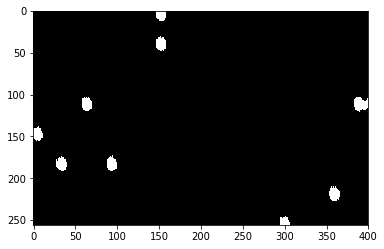

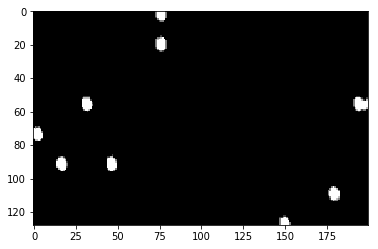

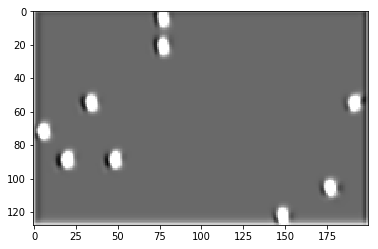

In [48]:
# Prediction using the data generator
params = {'dim': (500,256,400),
          'batch_size': 1,
          'n_channels': 1,
          'n_classes': 0,
          'shuffle': False,
          'dummy':True,
          'train':False}
predictor_generator = DataGenerator(predict_ids, **params)
stateless_generator = model_stateless.predict_generator(predictor_generator, steps = 1)
print('Machine output' + str(stateless_generator.shape))
predict = stateless_generator[0].reshape(22,128,200)

vect = np.load("dummies/label_200.npy")
print('Original output' + str(vect.shape))
truth = vect[0].reshape(256,400)
plt.imshow(truth, cmap = 'gray')
plt.show()
# resizing image with cv2
video = cv2.resize(truth,(200,128))
plt.imshow(video, cmap = 'gray')
plt.show()

#predicted result
plt.imshow(predict[21], cmap = 'gray')
plt.show()


In [44]:
# Predict using just a single sample loaded from file
data_loader = DataLoader()
X, y = data_loader.load_dummy(predict_ids[0])
X = np.expand_dims(X, axis = 0)
print(X.shape)
stateless_generator = model_stateless.predict_on_batch(np.expand_dims(X, axis = -1))
print(stateless_generator.shape)

(1, 22, 128, 200)
(1, 22, 128, 200, 1)


(1, 256, 400, 1)


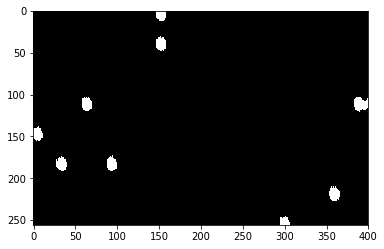

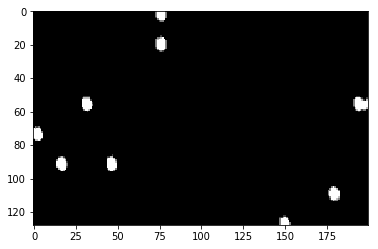

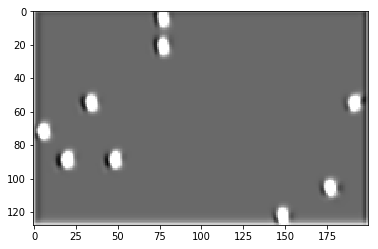

In [45]:
predict = stateless_generator[0].reshape(22,128,200)
vect = np.load("dummies/label_200.npy")
print(vect.shape)
truth = vect[0].reshape(256,400)
plt.imshow(truth, cmap = 'gray')
plt.show()
# resizing image with cv2
video = cv2.resize(truth,(200,128))
plt.imshow(video, cmap = 'gray')
plt.show()

#predicted result
plt.imshow(predict[21], cmap = 'gray')
plt.show()

Both of these create results that are 22 frames in length because the way LSTMs work is by making an LSTM for each frame in the series. The state is reset at the end of each series and thus is only remembered for each series. So although there is an LSTM step for each fram information is still passed from frame to frame to get a final result. 

Sateful LSTM

Stateful=False
In a stateful=False case, all the states are resetted together after each batch.

    A batch with 10 sequences would create 10 states, and all 10 states are resetted automatically after it's processed.

    The next batch with 10 sequences will create 10 new states, which will also be resetted after this batch is processed

If all those sequences have length (timesteps) = 7, the practical result of these two batches is:

    20 individual sequences, each with length 7

None of the sequences are related. But of course: the weights (not the states) will be unique for the layer, and will represent what the layer has learned from all the sequences.

    A state is: Where am I now inside a sequence? Which time step is it? How is this particular sequence behaving since its beginning up to now?
    A weight is: What do I know about the general behavior of all sequences I've seen so far?
Stateful=True
In this case, there is also the same number of parallel states, but they will simply not be resetted at all.

    A batch with 10 sequences will create 10 states that will remain as they are at the end of the batch.

    The next batch with 10 sequences (it's required to be 10, since the first was 10) will reuse the same 10 states that were created before.

The practical result is: the 10 sequences in the second batch are just continuing the 10 sequences of the first batch, as if there had been no interruption at all.

    If each sequence has length (timesteps) = 7, then the actual meaning is:

10 individual sequences, each with length 14

When you see that you reached the total length of the sequences, then you call model.reset_states(), meaning you will not continue the previous sequences anymore, now you will start feeding new sequences.


From https://www.reddit.com/r/MachineLearning/comments/4k3i2n/keras_stateful_lstm_what_am_i_missing/

Let me quote directly the keras FAQ about stateful recurrent layers:

When using stateful RNNs, it is therefore assumed that:

1. all batches have the same number of samples
2. If X1 and X2 are successive batches of samples, then X2[i] is the follow-up sequence to X1[i], for every i.

And also from the main docs:
"You can set RNN layers to be 'stateful', which means that the states computed for the samples in one batch will be reused as initial states for the samples in the next batch. This assumes a one-to-one mapping between samples in different successive batches"

Now, if I'm reading this right, given a list of 10 sequences [0,1,2,3,4,5,6,7,8,9] split into batches [0,1,2,3,4] and [5,6,7,8,9], does it mean that the model expects the couples of sequences (0,5), (1,6), (2,7), etc


The key thing is that it isn't backpropping across batches.

To get it to behave like a normal RNN you need to unroll time and set the batch size equal to the number of time steps. Then when you're training it's still doing truncated BPTT but the hidden state is initialized from the matching element of the previous batch rather than zero init each time.


Logic goes like this

    BatchSize = 5
    sequences = [ X[I::BatchSize] for I in xrange(BatchSize) ]

    batches   = [ sequences[:, N] for N in xrange(X.shape[0]/BatchSize) ]
    sequences[0] == [0, 5, 10, …]
    sequences[1] == [1, 6, 11, …]
    sequences[2] == [2, 7, 12, …] 
    sequences[3] == [3, 8, 13, …]   
    sequences[4] == [4, 9, 14, …]   

    batches[0] == [ 0,  1,  2,  3,  4]  
    batches[1] == [ 5,  6,  7,  8,  9]   
    batches[2] == [10, 11, 12, 13, 14]

The function below implements this

## STATEFUL batch_shape = [1, frag_len, x, y, 1]
    1 sample at a time
    update made after no_fragments batches
    y = [1, 1, x, y, 1]

In [144]:
def data_hankel(data, frag_len):
    # returns no_fragments of length frag_len for a single sample
    no_frags = int(len(data)/frag_len + 1)
    print(no_frags)
    hankel_matrix = [data[i:i+frag_len] for i in range(no_frags)]
    return np.array([hankel_matrix])

data = np.load("dummies/video_200.npy")

In [6]:
# Hankel matrix
frag_len = 3
data = np.load("dummies/video_200.npy")

In [6]:
frag_len = 5

In [29]:
class Batch_size_1_Generator(object):

    def __init__(self, frag_len):
        self.frag_len = frag_len
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        self.current_count = 0
        self.data = None
        #self.dup_rows()
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set

    def dup_rows(self, a, indx, num_dups=1):
        return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)
    
    def generate(self):
        # this generator returns no_frag fragments for each sample before moving to the next sample
        while True:
            #print(self.current_idx)
            #print(self.current_count)
           
            if self.current_count == 0:
                self.current_idx = np.random.randint(200)

            self.data = np.load('dummies/video_' + str(self.current_idx) + '.npy')
            # find out number of fragments for data
            no_frags = int(len(self.data)/self.frag_len)
            self.current_count += 1

            if self.current_count == no_frags:
                self.current_count = 0
            
            x = self.data[self.current_count:self.current_count+self.frag_len]
            print('current sample number ' + str(self.current_idx))
            print('fragment in sample ' + str(self.current_count))
            #print('No frags ' + str(no_frags))
            
            ysing = np.load('dummies/label_' + str(self.current_idx) + '.npy')
            y = np.expand_dims(self.dup_rows(ysing, 0, no_frags),axis = 0)
            x = np.expand_dims(x, axis=0)
            
           
            yield x,y

In [30]:
from keras.models import Model
from keras.layers.convolutional import Conv3D, Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, TimeDistributed
import keras.backend as K
import tensorflow as tf

K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

input_shape = (None, 256, 400, 1)
input = Input(batch_shape= [1, frag_len, 256,400, 1])

x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                   input_shape=input_shape,
                   padding='same', 
                   return_sequences=True,
                   stateful = True)(input)
x = BatchNormalization()(x)
x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(x)
# output = Conv3D(filters=1, kernel_size=(3, 3, 3),
#                    activation='sigmoid',
#                    padding='same', data_format='channels_last')(x)


model_stateful_batch1 = Model(inputs = [input], output=[output])
model_stateful_batch1.compile(loss='binary_crossentropy', optimizer='adadelta')
model_stateful_batch1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (1, 5, 256, 400, 1)       0         
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (1, 5, 256, 400, 14)      7616      
_________________________________________________________________
batch_normalization_7 (Batch (1, 5, 256, 400, 14)      56        
_________________________________________________________________
time_distributed_7 (TimeDist (1, 5, 256, 400, 2)       254       
_________________________________________________________________
output (TimeDistributed)     (1, 5, 256, 400, 1)       3         
Total params: 7,929
Trainable params: 7,901
Non-trainable params: 28
_________________________________________________________________


/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [31]:
frag_len = 5
gener = Batch_size_1_Generator(frag_len).generate()

In [32]:
# Train model on dataset
#  steps_per_epoch: It should typically be equal to the number of samples of your dataset divided by the batch size
#                   Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
#  epochs: An epoch is an iteration over the entire data provided, as defined by  steps_per_epoch
#          model is not trained for a number of iterations given by epochs but merely until the epoch of index epochs is reached

for reps in range(16):
    if reps%(frag_len-1) == 0:
        print ('Time to reset states')
        model_stateful_batch1.reset_states()
    train_loss = 0
    X,Y = next(gener)
    train_loss += model_stateful_batch1.train_on_batch(X, Y)
    #print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))
    print ('# epoch', reps, '  loss ', train_loss/float(Y.shape[0]))



Time to reset states
current sample number 184
fragment in sample 1
# epoch 0   loss  0.693134605884552
current sample number 184
fragment in sample 2
# epoch 1   loss  0.6913216710090637
current sample number 184
fragment in sample 3
# epoch 2   loss  0.6878215670585632
current sample number 184
fragment in sample 0
# epoch 3   loss  0.6859501004219055
Time to reset states
current sample number 169
fragment in sample 1
# epoch 4   loss  0.681623101234436
current sample number 169
fragment in sample 2
# epoch 5   loss  0.6793351769447327
current sample number 169
fragment in sample 3
# epoch 6   loss  0.6752641797065735
current sample number 169
fragment in sample 0
# epoch 7   loss  0.6706001162528992
Time to reset states
current sample number 165
fragment in sample 1
# epoch 8   loss  0.6568859815597534
current sample number 165
fragment in sample 2
# epoch 9   loss  0.6511321663856506
current sample number 165
fragment in sample 3
# epoch 10   loss  0.6364712119102478
current sample

In [33]:
# Predict using just a single sample loaded from file
gener = Batch_size_1_Generator(frag_len).generate()

current sample number 197
fragment in sample 1
(1, 5, 256, 400, 1)


(1, 256, 400, 1)


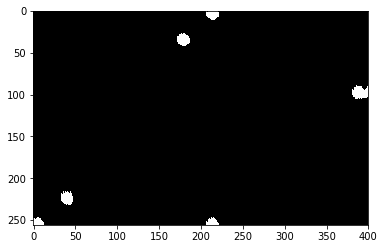

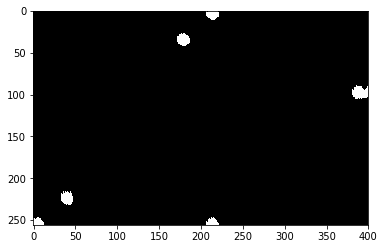

IndexError: index 5 is out of bounds for axis 0 with size 5

In [35]:
predicted = stateful_batch1[0].reshape(5,256,400)
vect = np.load("dummies/label_197.npy")
print(vect.shape)
truth = vect[0].reshape(256,400)
plt.imshow(truth, cmap = 'gray')
plt.show()
# resizing image with cv2
video = cv2.resize(truth,(400,256))
plt.imshow(video, cmap = 'gray')
plt.show()

#predicted result
plt.imshow(predicted[4], cmap = 'gray')
plt.show()

## STATEFUL batch_shape = [no_samples,frag_len , x, y, 1]
    no_samples samples at a time
    update made after no_fragments batches
    y = [no_samples, 1, x, y, 1]

In [5]:
# function to split a sequence into batches that match with keras stateful lstm
def split_seq(batch_size, seq_len, sample):
    new_sample = np.zeros((batch_size, seq_len))
    sample_reform = sample.reshape(seq_len,batch_size)
    for i in range (0,batch_size):
        new_sample[i] = sample_reform[:,i]
    return new_sample

In [6]:
sample = np.array((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20, 21, 22,23,24))

seq_len = 5
sample_len = len(sample)
batch_size_stateful = int(sample_len/seq_len)

split_seq(batch_size_stateful, seq_len, sample)

array([[ 0.,  5., 10., 15., 20.],
       [ 1.,  6., 11., 16., 21.],
       [ 2.,  7., 12., 17., 22.],
       [ 3.,  8., 13., 18., 23.],
       [ 4.,  9., 14., 19., 24.]])

In [88]:
batch_size = 2
seq_len = 11
sample_len = 22

In [ ]:
K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

input_shape = (None, 128, 200, 1)
input = Input(input_shape, name='input')

x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                   input_shape=input_shape,
                   padding='same', 
                   return_sequences=True,
                   batch_input_shape = (seq_len, batch_size , 128, 200, 1)
                   stateful = True)(input)
x = BatchNormalization()(x)
x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(x)
# output = Conv3D(filters=1, kernel_size=(3, 3, 3),
#                    activation='sigmoid',
#                    padding='same', data_format='channels_last')(x)


model_stateful = Model(inputs = [input], output = [output])
model_stateful.compile(loss='binary_crossentropy', optimizer='adadelta')
model_stateful.summary()